In [1]:
from agricultural_csp.instance import *
from agricultural_csp.evaluator import *
from agricultural_csp.solver.agcsp_ts import *

import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple

In [2]:
def display_grid_and_path(inst, evaluator, path):
    """
    Display a grid with nodes and path coverage visualization.
    
    Args:
        inst: AgcspInstance object containing grid_nodes and obstacle_nodes
        evaluator: AgcspEvaluator object to calculate coverage
        path: List of (row, col) tuples representing the path
    """
    covered_nodes = evaluator.get_covered_nodes_list(path)
    
    total_nodes = inst.target_node_count
    covered_count = len(covered_nodes)
    coverage_percentage = (covered_count / total_nodes) * 100 if total_nodes > 0 else 0
    
    # Check for obstacle coverage
    covered_obstacles = []
    obstacle_warning = ""
    if hasattr(inst, 'obstacle_nodes') and len(inst.obstacle_nodes) > 0:
        covered_set = set(map(tuple, covered_nodes))
        covered_obstacles = [obs for obs in inst.obstacle_nodes if tuple(obs) in covered_set]
        if covered_obstacles:
            obstacle_warning = f" - {len(covered_obstacles)} obstacles covered!"
    
    plt.figure(figsize=(12, 10))
    
    # Plot valid nodes
    plt.scatter(inst.grid_nodes[:, 0], inst.grid_nodes[:, 1], c='#AAAAAA', s=3, 
               label='Uncovered Nodes', alpha=0.7)
    
    if len(covered_nodes) > 0:
        plt.scatter(covered_nodes[:, 0], covered_nodes[:, 1], c='#00AA44', s=4, 
                   label='Covered Nodes', alpha=0.8)
    
    # Plot obstacles
    if hasattr(inst, 'obstacle_nodes') and len(inst.obstacle_nodes) > 0:
        plt.scatter(inst.obstacle_nodes[:, 0], inst.obstacle_nodes[:, 1], c='#CC0000', s=4, 
                   marker='s', label='Obstacles', linewidths=0.5)
        
        # Highlight covered obstacles
        if covered_obstacles:
            covered_obstacles_arr = np.array(covered_obstacles)
            plt.scatter(covered_obstacles_arr[:, 0], covered_obstacles_arr[:, 1], 
                       c='#FF6600', s=10, marker='D', 
                       linewidths=2, label='Covered Obstacles')
    
    # Plot path
    if len(path) > 0:
        path_arr = np.array(path)
        plt.plot(path_arr[:, 0], path_arr[:, 1], color='#9900CC', linewidth=3, 
                label='Sprayer Path', marker='o', markersize=6, markerfacecolor='white', 
                markeredgecolor='#9900CC', markeredgewidth=2)
    
    # Plot start point (green star)
    if len(path) > 0:
        plt.scatter(path_arr[0, 0], path_arr[0, 1], c='#00DD00', s=200, 
                   marker='*', label='Start', edgecolors='black', linewidths=2, zorder=5)
    
    # Plot end point (red square)
    if len(path) > 1:
        plt.scatter(path_arr[-1, 0], path_arr[-1, 1], c='#DD0000', s=100, 
                   marker='s', label='End', edgecolors='black', linewidths=2, zorder=5)
    
    plt.axis('equal')
    plt.legend(loc='upper right', framealpha=0.9)
    
    title = f'Coverage: {covered_count}/{total_nodes} nodes ({coverage_percentage:.1f}%){obstacle_warning}'
    plt.title(title, fontsize=12, fontweight='bold')
    
    print(f"Coverage: {covered_count}/{total_nodes} nodes ({coverage_percentage:.1f}%)")
    if hasattr(inst, 'obstacle_nodes') and len(inst.obstacle_nodes) > 0:
        print(f"Obstacles: {len(covered_obstacles)}/{len(inst.obstacle_nodes)} covered")
        if covered_obstacles:
            print("WARNING: Sprayer is covering obstacles!")
    
    plt.show()

In [3]:
# Create a 50 x 50 square grid with five small square obstacles scattered on the grid
obstacle_half_size = 2  # Half-size of each small square obstacle

r_grid, c_grid = np.mgrid[0:50, 0:50]
grid_nodes = np.argwhere((r_grid >= 0) & (r_grid < 50) & (c_grid >= 0) & (c_grid < 50))

# Create five small square obstacles at different positions on the grid
obstacle_positions = [
    (10, 10),  # Top-left area
    (10, 40),  # Top-right area
    (25, 25),  # Center
    (40, 10),  # Bottom-left area
    (40, 40)   # Bottom-right area
]

obstacle_list = []
for obs_r, obs_c in obstacle_positions:
    obstacle = np.argwhere(
        (np.abs(r_grid - obs_r) <= obstacle_half_size) & 
        (np.abs(c_grid - obs_c) <= obstacle_half_size)
    )
    obstacle_list.append(obstacle)

obstacle_nodes = np.vstack(obstacle_list)
instance = AgcspInstance(grid_nodes, obstacle_nodes, 5, 90)

""" instance = AgcspInstance(grid_nodes, np.array([]), 5, 90) """
evaluator = AgcspEvaluator(instance)


Grid Adaptativo: Densidade original (2500)
Grid Adaptativo: Nova densidade (reduzida) (1501 nós)


Coverage: 0/2375 nodes (0.0%)
Obstacles: 0/125 covered


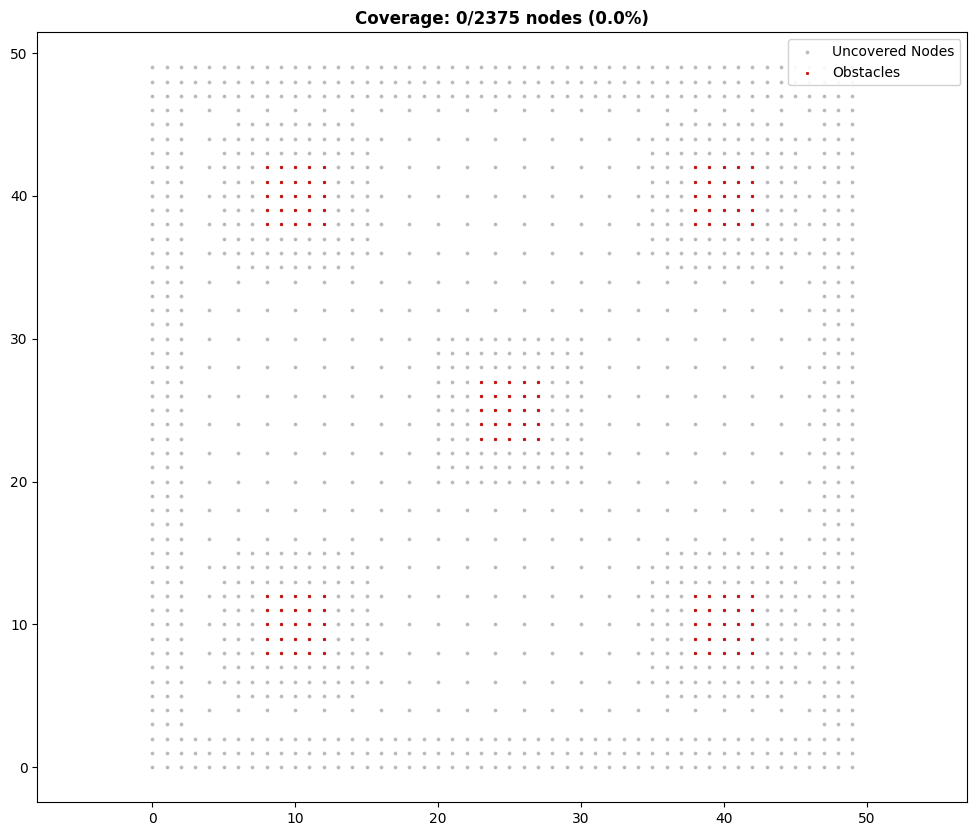

In [4]:
display_grid_and_path(inst=instance, evaluator=evaluator, path=[])

In [5]:
strategy = TSStrategy(
    constructive_heuristic=ConstructiveHeuristicType.FSM_COVERAGE_PLANNER,
    phased_optimization=PhasedOptimizationParams(phase_iterations=[5, 1, 5], degradation_tolerances=[0, 0, 0]),
    tabu_radius=3,
    search_strategy='first'
)

term_criteria = TerminationCriteria(max_iterations=10)
debug_options = DebugOptions(verbose=True)

ts = AgcspTS(instance, tenure=10, strategy=strategy, termination_criteria=term_criteria, debug_options=debug_options)

FSM Planner (Nearest Neighbor): Iniciando com 1115 nós alvo esparsos.
Path simplification reduced points from 1676 to 788.
Coverage: 1376/2375 nodes (57.9%)
Obstacles: 0/125 covered


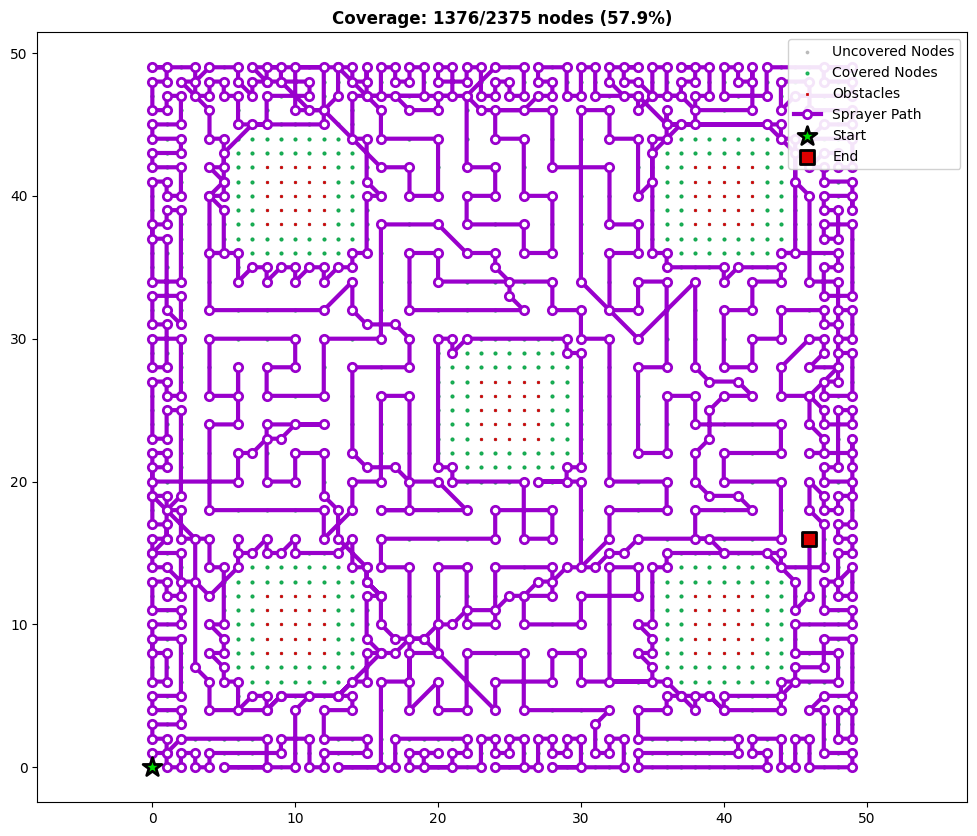

In [6]:
initial_sol = ts._constructive_heuristic(strategy.constructive_heuristic)
display_grid_and_path(instance, evaluator, initial_sol.path)

In [ ]:
solution = ts.solve(initial_solution=initial_sol)

--- Iniciando TS com solução fornecida. ---
-----------------------------------------------------------
Initial solution objective value: 3089.40
-----------------------------------------------------------
Iteration 0: Best ObjFun = 3089.40, Current ObjFun = 3089.40
--- Fase 1 estagnada (0 iterações). Trocando de fase. ---

=== Trocando para Fase 2 (Objetivo: Otimizar C2) ===
Iteration 1: Best ObjFun = 3089.40, Current ObjFun = 3089.40
Applying move: move with args (780, array([38, 16]))

=== Trocando para Fase 3 (Objetivo: Otimizar C3) ===
Iteration 2: Best ObjFun = 3088.54, Current ObjFun = 3088.54
Applying move: remove with args (194,)
Iteration 3: Best ObjFun = 3084.13, Current ObjFun = 3084.13
Applying move: remove with args (547,)
Iteration 4: Best ObjFun = 3080.19, Current ObjFun = 3080.19
Applying move: insert with args ((np.int64(13), np.int64(45)), 521)
Iteration 5: Best ObjFun = 3080.19, Current ObjFun = 3080.19


Coverage: 966/2375 nodes (40.7%)
Obstacles: 0/125 covered


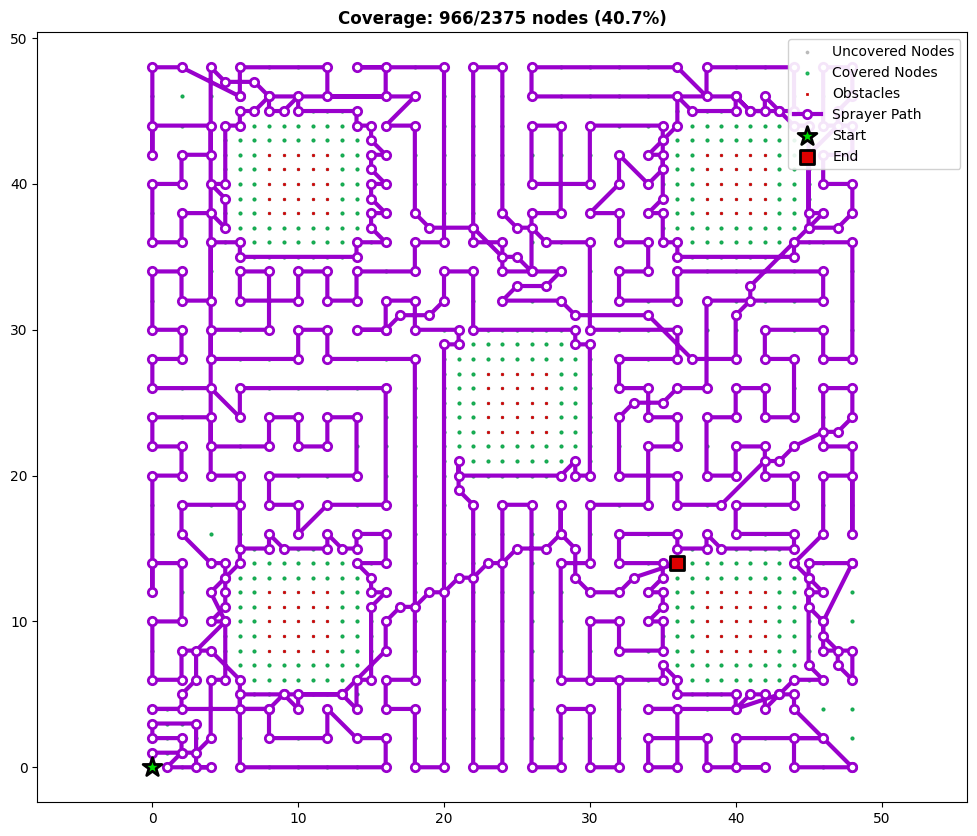

In [ ]:
last_solution = ts._current_solution
display_grid_and_path(instance, evaluator, last_solution.path)

In [ ]:
solution.cache["hits_obstacle"]

np.False_

In [ ]:
strategy = TSStrategy(
    constructive_heuristic=ConstructiveHeuristicType.FSM_COVERAGE_PLANNER,
    phased_optimization=PhasedOptimizationParams(phase_iterations=[5, 1, 5], degradation_tolerances=[0, 0, 0]),
    tabu_radius=3,
    search_strategy='best'
)

term_criteria = TerminationCriteria(max_iterations=100)
debug_options = DebugOptions(verbose=True)

ts = AgcspTS(instance, tenure=10, strategy=strategy, termination_criteria=term_criteria, debug_options=debug_options)

FSM Planner (Nearest Neighbor): Iniciando com 705 nós alvo esparsos.
Path simplification reduced points from 1344 to 499.
Coverage: 966/2375 nodes (40.7%)
Obstacles: 0/125 covered


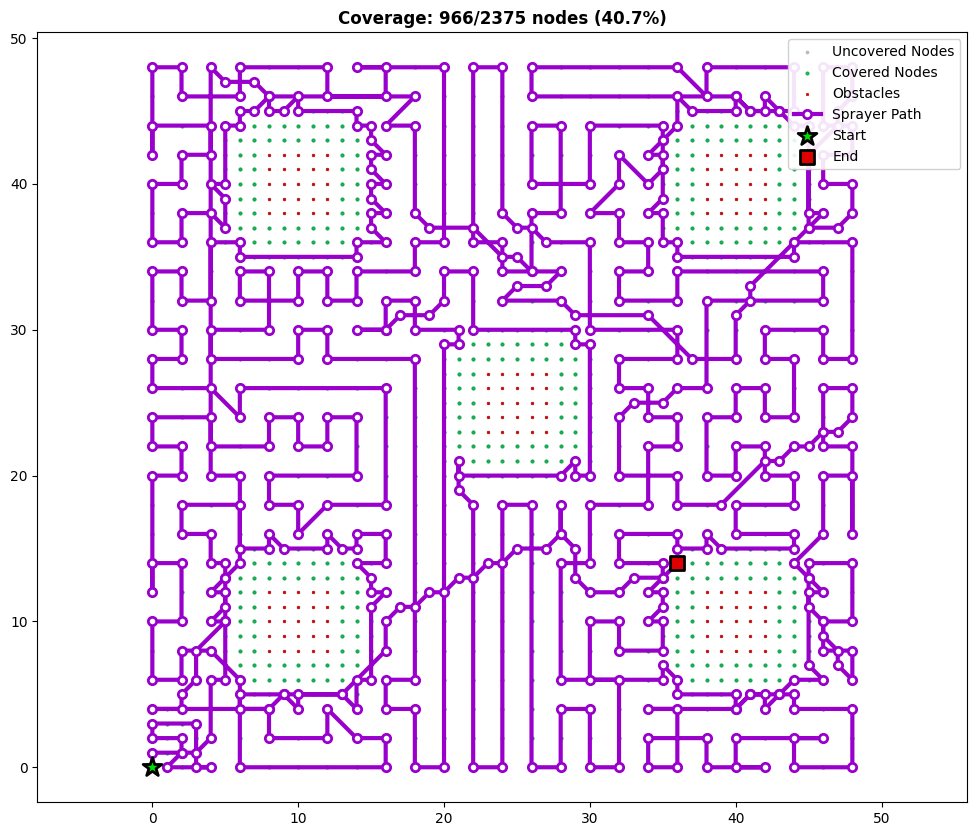

In [ ]:
initial_sol = ts._constructive_heuristic(strategy.constructive_heuristic)
display_grid_and_path(instance, evaluator, initial_sol.path)

In [ ]:
solution = ts.solve(initial_solution=initial_sol)

--- Iniciando TS com solução fornecida. ---
-----------------------------------------------------------
Initial solution objective value: 2483.12
-----------------------------------------------------------
Iteration 0: Best ObjFun = 2483.12, Current ObjFun = 2483.12
--- Fase 1 estagnada (0 iterações). Trocando de fase. ---

=== Trocando para Fase 2 (Objetivo: Otimizar C2) ===
Iteration 1: Best ObjFun = 2483.12, Current ObjFun = 2483.12
** BEST IMPROVING ACEITO ** Tipo: remove, Delta Foco (1): -4.5822
Applying move: remove with args (459,)

=== Trocando para Fase 3 (Objetivo: Otimizar C3) ===
Iteration 2: Best ObjFun = 2475.01, Current ObjFun = 2475.01
** BEST IMPROVING ACEITO ** Tipo: move, Delta Foco (2): -3.8944
Applying move: move with args (329, array([42,  0]))
Iteration 3: Best ObjFun = 2469.58, Current ObjFun = 2469.58


KeyboardInterrupt: 

Coverage: 338/910 nodes (37.1%)
Obstacles: 0/125 covered


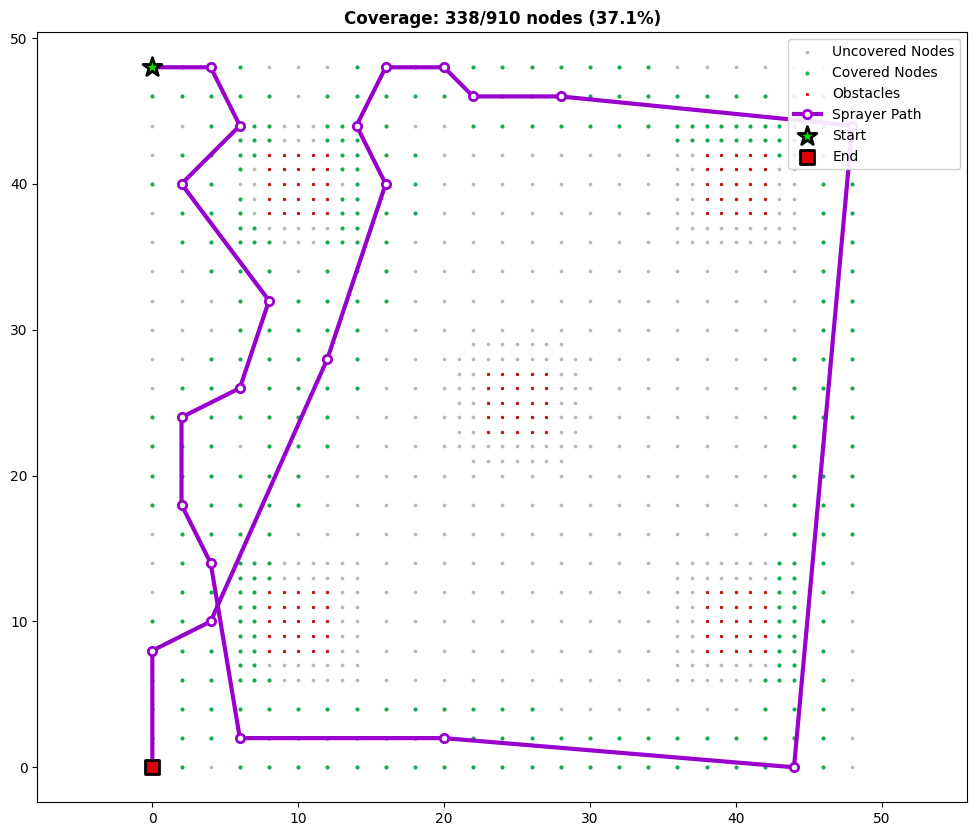

In [ ]:
last_solution = ts._current_solution
display_grid_and_path(instance, evaluator, last_solution.path)

In [ ]:
strategy = TSStrategy(
    constructive_heuristic=ConstructiveHeuristicType.BOUSTROPHEDON_SEGMENTED,
    phased_optimization=PhasedOptimizationParams(phase_iterations=[5, 1, 5], degradation_tolerances=[0, 0, 0]),
    tabu_radius=3,
    search_strategy='best'
)

term_criteria = TerminationCriteria(max_iterations=100)
debug_options = DebugOptions(verbose=True)

ts = AgcspTS(instance, tenure=10, strategy=strategy, termination_criteria=term_criteria, debug_options=debug_options)

  Iniciando em (np.int64(0), np.int64(2))
Coverage: 48/910 nodes (5.3%)
Obstacles: 0/125 covered


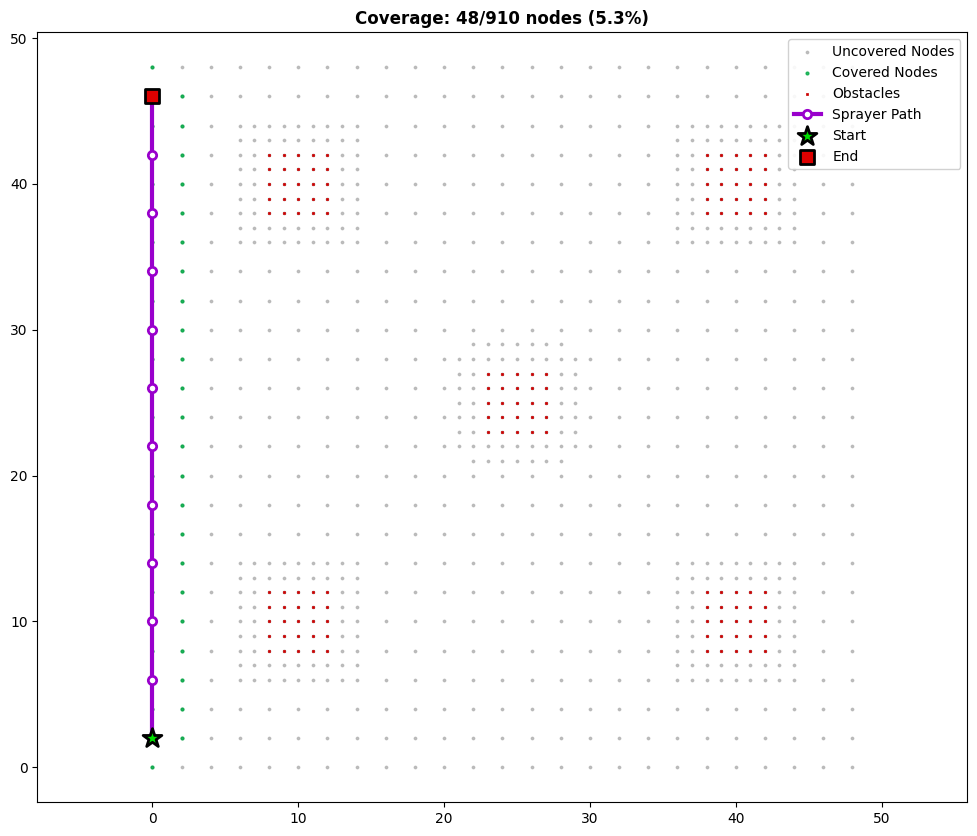

In [ ]:
initial_sol = ts._constructive_heuristic(strategy.constructive_heuristic)
display_grid_and_path(instance, evaluator, initial_sol.path)

In [ ]:
solution = ts.solve(initial_solution=initial_sol)

--- Iniciando TS com solução fornecida. ---
-----------------------------------------------------------
Initial solution objective value: 935.61
-----------------------------------------------------------
Iteration 0: Best ObjFun = 935.61, Current ObjFun = 935.61
** BEST IMPROVING PHASADO ACEITO ** Tipo: insert, Delta Foco (0): -21.0737
Applying move: insert with args ((np.int64(48), np.int64(48)), 12)
Iteration 1: Best ObjFun = 935.61, Current ObjFun = 963.53
** BEST IMPROVING PHASADO ACEITO ** Tipo: insert, Delta Foco (0): -19.9242
Applying move: insert with args ((np.int64(48), np.int64(0)), 0)
Iteration 2: Best ObjFun = 935.61, Current ObjFun = 992.61
** BEST IMPROVING PHASADO ACEITO ** Tipo: move, Delta Foco (0): -5.3642
Applying move: move with args (1, array([0, 6]))
Iteration 3: Best ObjFun = 935.61, Current ObjFun = 982.62
** BEST IMPROVING PHASADO ACEITO ** Tipo: insert, Delta Foco (0): -6.1305
Applying move: insert with args ((np.int64(8), np.int64(18)), 1)
Iteration 4: Best

Coverage: 684/910 nodes (75.2%)
Obstacles: 0/125 covered


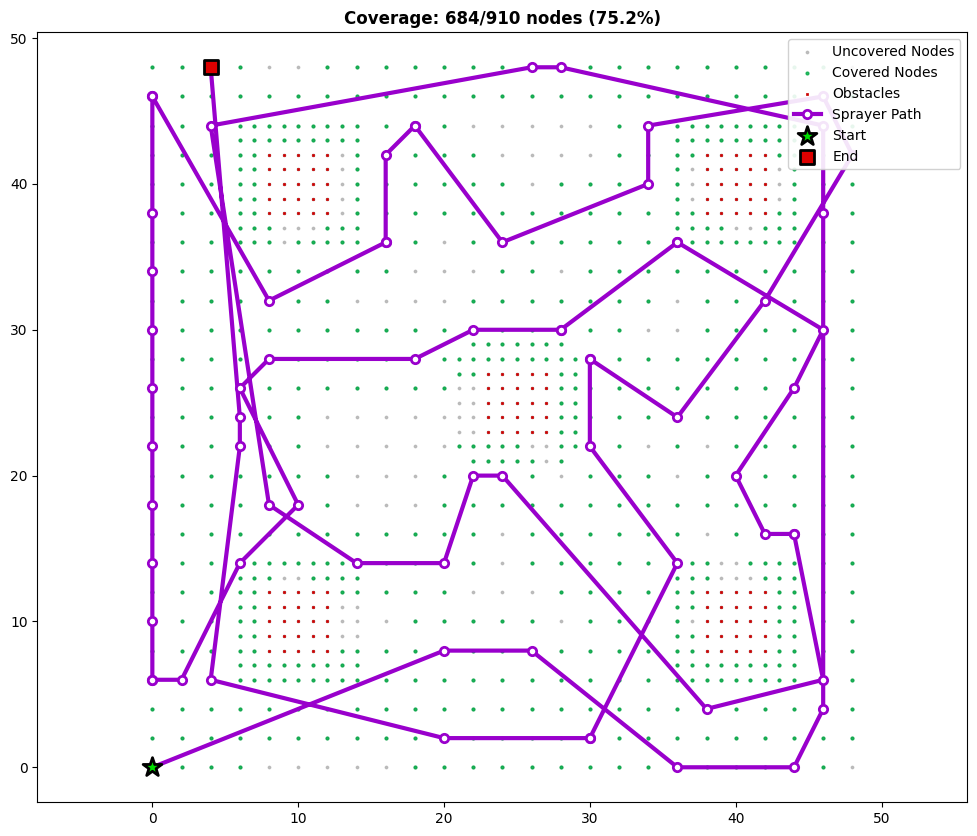

In [ ]:
last_solution = ts._current_solution
display_grid_and_path(instance, evaluator, last_solution.path)